In [1]:
%load_ext lab_black
import pandas as pd
import json


f = open("histoday_BTC.json",)
data = json.load(f)
data = pd.DataFrame.from_dict(data["Data"]["Data"])
data = data[["time", "close"]]
f.close()
# data

In [2]:
def get_profit(lower_limit, upper_limit):
    i = 0
    profit = 0
    records = []
    n = 0
    for index, row in data.iterrows():
        day = index
        price = row["close"]
        if i % 2 == 0:
            if row["RSI"] <= lower_limit and n == 0:
                profit -= price
                records.append(["Buying", -round(price), round(profit), day])
                n += 1
                i += 1
        else:
            if row["RSI"] >= upper_limit and n >= 0 and profit + price >= 1:
                profit += price
                records.append(["Selling", round(price), round(profit), day])
                n -= 1
                i += 1
    return profit


def calculation(data, window_length, lower_limit, upper_limit):
    delta = data["close"].diff()
    up, down = delta.copy(), delta.copy()
    up[up <= 1] = 0
    down[down >= 2] = 0
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    data.loc[:, "RSI"] = RSI1
    data.loc[:, "TimeStamp"] = pd.to_datetime(data["time"], unit="s")
    data = data.set_index("TimeStamp")
    return get_profit(lower_limit, upper_limit)


calculation(data, 14, 50, 60)

-39565.07

In [3]:
window_length = 12
lower_limit = 21
upper_limit = 92

In [4]:
def get_profit(lower_limit, upper_limit):
    i = 0
    profit = 0
    records = []
    n = 0
    for index, row in data.iterrows():
        day = index
        price = row["close"]
        if i % 2 == 0:
            if row["RSI"] <= lower_limit and n == 0:
                profit -= price
                records.append(["Buying", -round(price), round(profit), day])
                n += 1
                i += 1
        else:
            if row["RSI"] >= upper_limit and n >= 0 and profit + price >= 1:
                profit += price
                records.append(["Selling", round(price), round(profit), day])
                n -= 1
                i += 1
    return records, profit


def calculation(data, window_length, lower_limit, upper_limit):
    delta = data["close"].diff()
    up, down = delta.copy(), delta.copy()
    up[up <= 1] = 0
    down[down >= 2] = 0
    roll_up1 = up.ewm(span=window_length).mean()
    roll_down1 = down.abs().ewm(span=window_length).mean()
    RS1 = roll_up1 / roll_down1
    RSI1 = 100.0 - (100.0 / (1.0 + RS1))
    data.loc[:, "RSI"] = RSI1
    data.loc[:, "TimeStamp"] = pd.to_datetime(data["time"], unit="s")
    data = data.set_index("TimeStamp")
    records, profit = get_profit(lower_limit, upper_limit)
    return records, profit


records, profit = calculation(data, window_length, lower_limit, upper_limit)
formated_profit = f"{round(profit):,}"
print(f"Total profit: USD {formated_profit}\n")
records_df = pd.DataFrame(records, columns=["Action", "Price", "Profit", "Day"])
pd.set_option("max_rows", 30)
records_df

Total profit: USD 5,966



,Action,Price,Profit,Day
0,Buying,-372,-372,78
1,Selling,584,211,221
2,Buying,-622,-411,276
3,Selling,715,304,366
4,Buying,-971,-667,506
5,Selling,1416,749,550
6,Buying,-1975,-1226,625
7,Selling,4328,3102,655
8,Buying,-3243,-141,686
9,Selling,5637,5496,715


In [5]:
data = data[["close", "TimeStamp"]]

<AxesSubplot:>

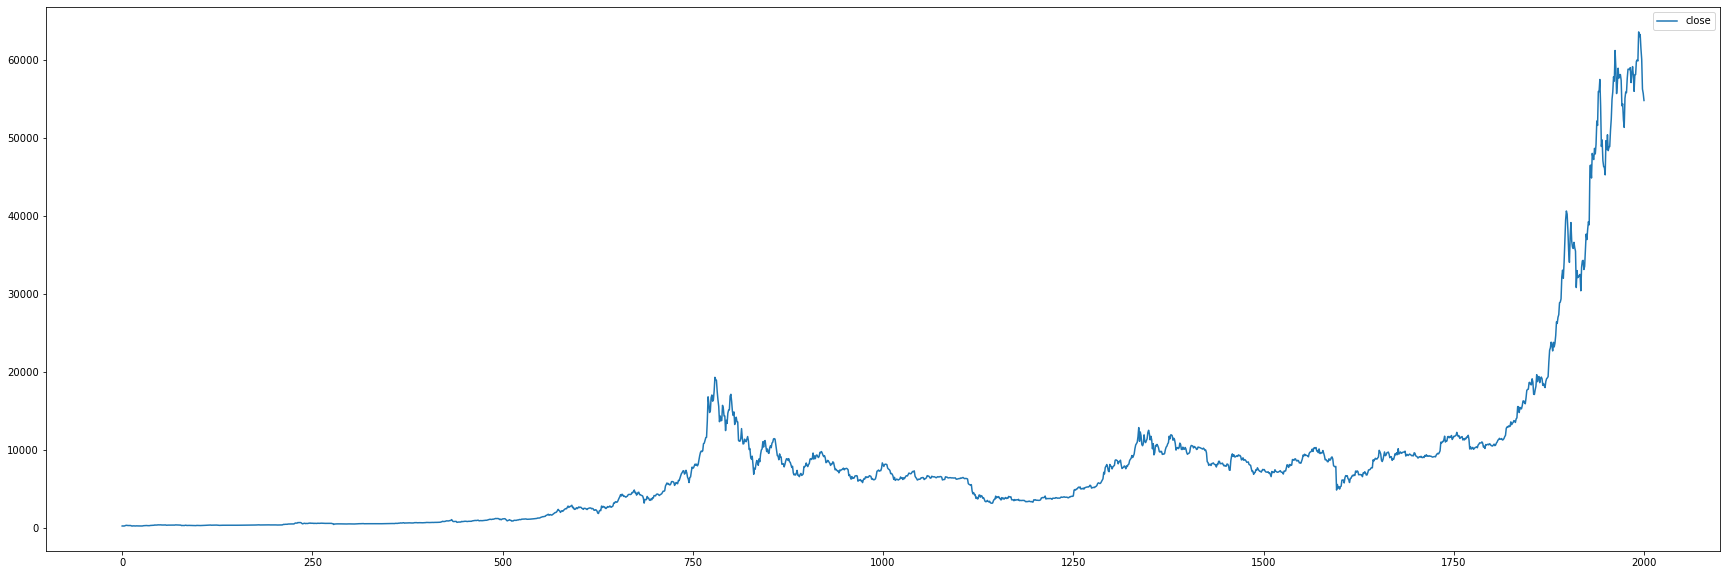

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
fig, ax = plt.subplots(figsize=(30, 10))
# plt.ylim(0, 100)
data[["close"]].plot(ax=ax)

In [7]:
lowest_price = 25000
r = 0.02
prices = [lowest_price * (1 + r) ** i for i in range(0, 50)]
# prices

In [8]:
data

,close,TimeStamp
0,313.63,2015-10-29
1,327.12,2015-10-30
2,311.24,2015-10-31
3,322.95,2015-11-01
4,359.28,2015-11-02
...,...,...
1996,61416.41,2021-04-16
1997,60056.07,2021-04-17
1998,56246.82,2021-04-18
1999,55680.11,2021-04-19


In [15]:
cash = 1000000
profit = 0
records = []
n = 0
last_price = 0
lower_bound = 50000
upper_bound = 70000
r = 0.003
fee = 0.002
for index, row in data.iterrows():
    time = index
    price = row["close"]
    if last_price == 0:
        last_price = price
    if lower_bound <= price <= upper_bound:
        if n == 0 and price <= last_price * (1 - r) and cash - price > 0:
            n += cash // price
            cash -= price * n * (1 + fee)
            profit = cash - 100000
            records.append(
                ["Buying", -round(price), n, round(cash), round(profit), time]
            )
            last_price = price
        elif n > 0 and price >= last_price * (1 + r):
            cash += price * n * (1 - fee)
            profit = cash - 100000
            records.append(
                ["Selling", round(price), 0, round(cash), round(profit), time]
            )
            last_price = price
            n = 0

pd.set_option("display.max_rows", None, "display.max_columns", None)
records_df = pd.DataFrame(
    records, columns=["Action", "Price", "n", "Cash", "Profit", "Day"]
)
print(records_df)

Empty DataFrame
Columns: [Action, Price, n, Cash, Profit, Day]
Index: []


In [17]:
%%time
def get_profit(r):
    cash = 1000000
    profit = 0
    records = []
    n = 0
    last_price = 0
    lower_bound = 30000
    upper_bound = 60000
    r = 0.001
    fee = 0.002
    for index, row in data.iterrows():
        time = index
        price = row["close"]
        if last_price == 0:
            last_price = price
        if lower_bound <= price <= upper_bound:
            if n == 0 and price <= last_price * (1 - r) and cash - price > 0:
                n += cash // price
                cash -= price * n * (1 + fee)
                profit = cash - 100000
                records.append(
                    ["Buying", -round(price), n, round(cash), round(profit), time]
                )
                last_price = price
            elif n > 0 and price >= last_price * (1 + r):
                cash += price * n * (1 - fee)
                profit = cash - 100000
                records.append(
                    ["Selling", round(price), 0, round(cash), round(profit), time]
                )
                last_price = price
                n = 0
    return profit


import numpy as np
from tqdm import tqdm
optimization_r=[]
for r in tqdm(np.arange(0.0001,0.3,0.0001)):
    profit=get_profit(r)
    optimization_r.append([r, profit])
optimization_r_df = pd.DataFrame(optimization_r, columns=["Rate", "Profit"])
pd.set_option("display.max_rows", None, "display.max_columns", None)
# print(optimization_r_df)
optimization_r_df[optimization_r_df["Profit"] == optimization_r_df["Profit"].max()]

100%|██████████| 2999/2999 [16:25<00:00,  3.04it/s]


Wall time: 16min 25s


,Rate,Profit
0,0.0001,0
1,0.0002,0
2,0.0003,0
3,0.0004,0
4,0.0005,0
5,0.0006,0
6,0.0007,0
7,0.0008,0
8,0.0009,0
9,0.0010,0


In [13]:
optimization_r_df

,Rate,Profit
0,0.0001,0
1,0.0002,0
2,0.0003,0
3,0.0004,0
4,0.0005,0
5,0.0006,0
6,0.0007,0
7,0.0008,0
8,0.0009,0
9,0.0010,0
